In [ ]:
#Binary Classification of fetal ultrasound images using a ResNet50 Architecture and Segmented dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
import pathlib

train_dir = '/Users/RishiSingh/crl-images/dataset/Dataset101/Training'

val_dir = '/Users/RishiSingh/crl-images/dataset/Dataset101/Testing'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 720 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(val_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 180 files belonging to 2 classes.


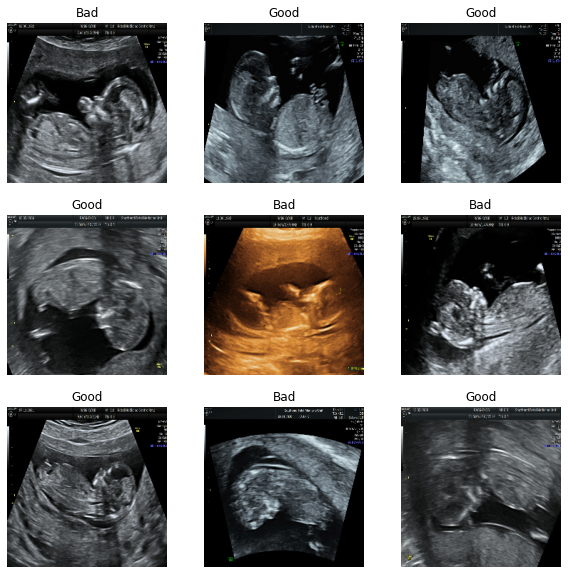

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

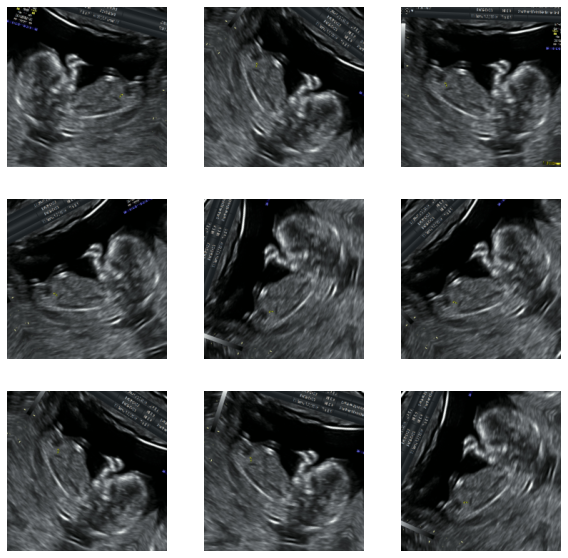

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [12]:
base_model.trainable = False

In [13]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

__________________________________________________________________________________________________
conv5_block1_3_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_add (Add)          (None, 7, 7, 2048)   0           conv5_block1_0_bn[0][0]          
                                                                 conv5_block1_3_bn[0][0]          
__________________________________________________________________________________________________
conv5_block1_out (Activation)   (None, 7, 7, 2048)   0           conv5_block1_add[0][0]           
__________________________________________________________________________________________________
conv5_block2_1_conv (Conv2D)    (None, 7, 7, 512)    1049088     conv5_block1_out[0][0]           
__________________________________________________________________________________________________
conv5_bloc

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [16]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 0.0002
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [19]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(validation_dataset)

5/5 [==============================] - 55s 8s/step - loss: 1.2285 - accuracy: 0.5331


In [20]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50
23/23 [==============================] - 172s 7s/step - loss: 0.8494 - accuracy: 0.4806 - val_loss: 0.8730 - val_accuracy: 0.4797
Epoch 2/50
23/23 [==============================] - 152s 6s/step - loss: 0.7612 - accuracy: 0.4972 - val_loss: 0.7916 - val_accuracy: 0.4932
Epoch 3/50
23/23 [==============================] - 172s 7s/step - loss: 0.6844 - accuracy: 0.5556 - val_loss: 0.7293 - val_accuracy: 0.5203
Epoch 4/50
23/23 [==============================] - 184s 8s/step - loss: 0.6334 - accuracy: 0.5889 - val_loss: 0.6525 - val_accuracy: 0.6081
Epoch 5/50
23/23 [==============================] - 175s 8s/step - loss: 0.5914 - accuracy: 0.6375 - val_loss: 0.6158 - val_accuracy: 0.6284
Epoch 6/50
23/23 [==============================] - 181s 8s/step - loss: 0.5636 - accuracy: 0.6819 - val_loss: 0.5857 - val_accuracy: 0.6419
Epoch 7/50
23/23 [==============================] - 171s 7s/step - loss: 0.5534 - accuracy: 0.6708 - val_loss: 0.5806 - val_accuracy: 0.6554
Epoch 8/50
23

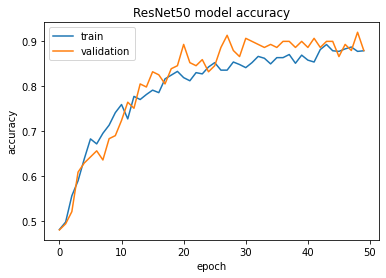

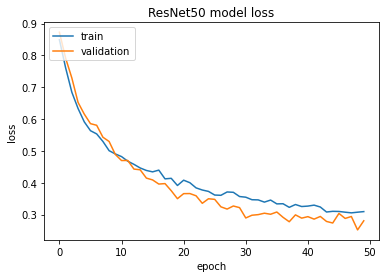

In [21]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Model-accuracy-ResNet(5).svg')
plt.show()
    
    # "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Model-loss-ResNet(5).svg')
plt.show()



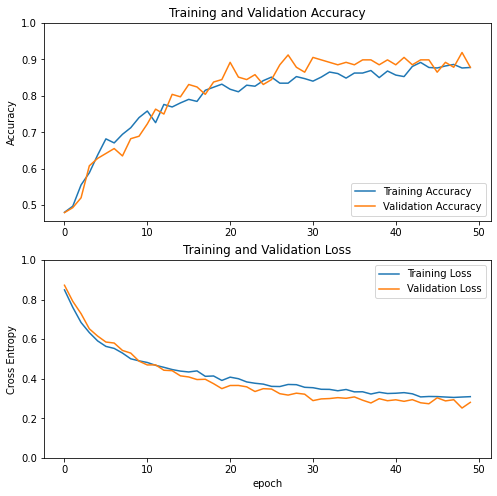

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

['Bad', 'Good']
bad
[[0.31613776]]


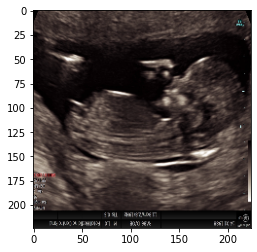

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from keras.preprocessing import image
from cv2 import *
import numpy as np
import matplotlib.image as mpimg
from keras.preprocessing import image
img = cv2.imread('/Users/RishiSingh/crl-images/dataset/single_prediction/CRL (180).jpg')
img = cv2.resize(img, (224,224))
plt.imshow(img)
test_image = image.load_img('/Users/RishiSingh/crl-images/dataset/single_prediction/CRL (180).jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(class_names)
if result[0][0] >0.5:
    prediction = 'good'
else:
    prediction = 'bad'
print(prediction)
print(result)

